In [1]:
import random
import json 
import time
import copy

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer


import torch

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR

from torchvision import models
from torchsummary import summary

# !pip install transformers
import transformers
from transformers import BertTokenizer, BertModel, BertConfig, AdamW

import matplotlib.pyplot as plt
import seaborn as sns

#from apex import amp

# ensure reproducability
#torch.seed(25)
torch.manual_seed(25)
torch.cuda.manual_seed_all(25)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(25)
random.seed(25)



In [2]:
# Initialization
opt_level = 'O1'
#apex.amp.initialize(model, optimizer, opt_level=opt_level)

torch.cuda.amp.GradScaler(
    init_scale=65536.0, growth_factor=2.0, backoff_factor=0.5,
    growth_interval=2000, enabled=True
)


In [3]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device = 'cuda'

In [4]:
print(device)

cuda


source
https://colab.research.google.com/drive/1d8N-ZLDS4FcmBDDG19gxbt_lSKglnwKq#scrollTo=mgX-jLdjw3Hl <br>
https://github.com/kaushaltrivedi/bert-toxic-comments-multilabel/blob/master/toxic-bert-multilabel-classification.ipynb

<br>
optimized with: <br>
https://pytorch.org/docs/stable/notes/amp_examples.html

<br>
Additional info <br>
https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1

In [5]:
#df = pd.read_csv("./data/train.csv")
#df['list'] = df[df.columns[2:]].values.tolist()
#new_df = df[['comment_text', 'list']].copy()
#new_df.head()

In [6]:
def extract_json_object(filename):
    with open(file, "r", encoding='utf-8') as read_file:
        json_array = json.load(read_file)
    json_data = []    
    #parse the data
    for item in json_array:
        details = {"id":None, "labels":None, "text":None}
        details['id'] = item['id']
        try: 
            details['labels'] = item['labels']
        except KeyError: 
            details['labels'] = []         
        details['text'] = item['text']
        json_data.append(details)

    
    return json_data






In [7]:
# file paths
lst_file_path=[]

lst_file_path.append("../data/training_data_task3.txt")

lst_file_path.append("../data/validation_data_task3.txt")


# List of keys 
dataset = ["training", "validation"] 
# empty dictionary
dic_datasets =  dict.fromkeys(dataset, pd.DataFrame()) 


In [8]:
for i, file in enumerate(lst_file_path):
    print('loading'+ file)
    dic_datasets[dataset[i]] = pd.DataFrame(extract_json_object(extract_json_object))

loading../data/training_data_task3.txt
loading../data/validation_data_task3.txt


In [9]:
df_training = pd.DataFrame(dic_datasets['training'][['id','labels','text']])
df_training.labels = df_training.labels.apply(lambda y: ['no_class'] if len(y)==0 else y)

df_val = pd.DataFrame(dic_datasets['validation'][['id','labels','text']])
df_val.labels = df_val.labels.apply(lambda y: ['no_class'] if len(y)==0 else y)


In [10]:
print('average sentence length: ', df_training.text.str.split().str.len().mean())
print('stdev sentence length: ', df_training.text.str.split().str.len().std())

average sentence length:  18.264099037138926
stdev sentence length:  11.755503545808766


In [43]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 20
freeze_layer_count = 11
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 25
#LEARNING_RATE = 1e-05
#LEARNING_RATE = 0.000009
LEARNING_RATE = None
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

BERT input representation. The input embeddings are the sum of the token embeddings, the segmentation embeddings and the position embeddings. <br>
The first token of every sequence is always a special clas- sification token ([CLS]). <br>
The final hidden state corresponding to this token is used as the ag- gregate sequence representation for classification tasks. Sentence pairs are packed together into a single sequence. <br>
We differentiate the sentences in two ways. First, we separate them with a special token ([SEP]). Second, we add a learned embed- ding to every token indicating whether it belongs to sentence A or sentence B. <br>
A positional embedding is also added to each token to indicate its position in the sequence. <br>
We are required to: <br>
Add special tokens to the start and end of each sentence. <br>
Pad & truncate all sentences to a single constant length. <br>
Explicitly differentiate real tokens from padding tokens with the “attention mask”. <br>

[SEP] <br>
At the end of every sentence, we need to append the special [SEP] token. <br>
This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?).<br>
Here we are not certain yet why the token is still required when we have only single-sentence input, but it is! <br>
[CLS]<br>
For classification tasks, we must prepend the special [CLS] token to the beginning of every sentence.<br>

For classification tasks, we must prepend the special [CLS] token to the beginning of every sentence.
This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).
On the output of the final (12th) transformer, only the first embedding (corresponding to the [CLS] token) is used by the classifier.
“The first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks.”
Also, because BERT is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector.

In [12]:
# note: a gelu hidden activation function is being usedf

In [13]:

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig(vocab_size=30522, hidden_size=768, num_hidden_layers=12, num_attention_heads=12, 
                           intermediate_size=3072, hidden_act='gelu', 
                           hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1, 
                           max_position_embeddings=512, type_vocab_size=2, initializer_range=0.02, 
                           layer_norm_eps=1e-12, pad_token_id=0, 
                           gradient_checkpointing=False, position_embedding_type='absolute', use_cache=True)



In [14]:
df_training.text.index

RangeIndex(start=0, stop=727, step=1)

In [15]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.text
        self.targets = self.data[[
                                    'Appeal to authority',
                                    'Appeal to fear/prejudice',
                                    'Black-and-white Fallacy/Dictatorship',
                                    'Causal Oversimplification',
                                    'Doubt',
                                    'Exaggeration/Minimisation',
                                    'Flag-waving',
                                    'Glittering generalities (Virtue)',
                                    'Loaded Language',
                                    'Misrepresentation of Someone\'s Position (Straw Man)',
                                    'Name calling/Labeling',
                                    'Obfuscation, Intentional vagueness, Confusion',
                                    'Presenting Irrelevant Data (Red Herring)',
                                    'Reductio ad hitlerum',
                                    'Repetition',
                                    'Slogans',
                                    'Smears',
                                    'Thought-terminating cliché',
                                    'Whataboutism',
                                    'Bandwagon',
                                    'Transfer',
                                    'Appeal to (Strong) Emotions'
                                ]].to_numpy()
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        #print(index)
        #print(self.comment_text.index)
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        # inputs = self.tokenizer.encode_plus(
        #    comment_text,
        #    None,
        #    add_special_tokens=True,
        #    truncation=True,
        #    max_length=self.max_len,
        #    pad_to_max_length=True,
        #    #padding=True,
        #    #padding='longest',
        #    return_token_type_ids=True
        # )
        inputs = tokenizer.encode_plus(
                    comment_text, 
                    add_special_tokens = True,    
                    truncation = True, 
                    max_length=self.max_len,
                    padding = "max_length", 
                    return_attention_mask = True, 
                    #return_tensors = "pt"
                    return_token_type_ids=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [16]:
#new_df[1:1000]

In [17]:
mlb = MultiLabelBinarizer(sparse_output=True)

df_concat_labels = pd.concat([df_training.pop('labels'), df_val.pop('labels')])
concat_labels = df_training.join(pd.DataFrame.sparse.from_spmatrix(
                    mlb.fit_transform(df_concat_labels),
                    index=df_concat_labels.index,
                    columns=mlb.classes_))


df_training = concat_labels[0:len(df_training)]
df_training.reset_index(inplace=True)

df_val = concat_labels[len(df_training):]
df_val.reset_index(inplace=True)

In [18]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8

#new_df2 = new_df[1:200]
train_dataset=df_training
test_dataset=df_val
#train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df_concat_labels.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)


dataset_size = len(train_dataset)

FULL Dataset: (867,)
TRAIN Dataset: (727, 26)
TEST Dataset: (140, 26)


In [19]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [20]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

#class BERTClass(torch.nn.Module):
# Initializing a model from the bert-base-uncased style configuration

class BertClass(transformers.PreTrainedModel):
    def __init__(self, config):
        super(BertClass, self).__init__(config)
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.5)
        self.l3 = torch.nn.Linear(768, 22)
    #768
    def forward(self, ids, mask, token_type_ids):
        #print(ids)
        #print(mask)
        #_,
        #print(type(self.l1(input_ids =ids, attention_mask = mask, token_type_ids = token_type_ids)))
        #print(self.l1(input_ids =ids, attention_mask = mask, token_type_ids = token_type_ids))
        # transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions -> out of self.l1, need the tensor poooler_output
        output_1= self.l1(input_ids =ids, attention_mask = mask, token_type_ids = token_type_ids).pooler_output
        #print(output_1)
        #print(type(output_1))
        #print(_)
        #print(type(_))
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output




In [21]:
model = BertClass(configuration)
# Accessing the model configuration
configuration = model.config

#freeze model
if freeze_layer_count:
# We freeze here the embeddings of the model
    for param in model.l1.embeddings.parameters():
        param.requires_grad = False

    if freeze_layer_count != -1:
        # if freeze_layer_count == -1, we only freeze the embedding layer
        # otherwise we freeze the first `freeze_layer_count` encoder layers
        for layer in model.l1.encoder.layer[:freeze_layer_count]:
            for param in layer.parameters():
                param.requires_grad = False

# learnable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)




7695382


In [22]:
# view layers

In [23]:
for name, param in model.named_parameters():
    #print(name)
    if param.requires_grad:
        print(name)

l1.encoder.layer.11.attention.self.query.weight
l1.encoder.layer.11.attention.self.query.bias
l1.encoder.layer.11.attention.self.key.weight
l1.encoder.layer.11.attention.self.key.bias
l1.encoder.layer.11.attention.self.value.weight
l1.encoder.layer.11.attention.self.value.bias
l1.encoder.layer.11.attention.output.dense.weight
l1.encoder.layer.11.attention.output.dense.bias
l1.encoder.layer.11.attention.output.LayerNorm.weight
l1.encoder.layer.11.attention.output.LayerNorm.bias
l1.encoder.layer.11.intermediate.dense.weight
l1.encoder.layer.11.intermediate.dense.bias
l1.encoder.layer.11.output.dense.weight
l1.encoder.layer.11.output.dense.bias
l1.encoder.layer.11.output.LayerNorm.weight
l1.encoder.layer.11.output.LayerNorm.bias
l1.pooler.dense.weight
l1.pooler.dense.bias
l3.weight
l3.bias


In [24]:
#model.l1.embeddings

In [25]:
#model.l1.encoder

In [26]:
#for param in model.parameters():
#    print(parm)
#    print(type(param), param.size())

In [27]:

model.to(device)


BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [28]:
print(model.config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.3.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



why this loss function was selected:
nn.CrossEntropyLoss uses the target to index the logits in your model’s output.<br>
Thus it is suitable for multi-class classification use cases (only one valid class in the target). <br>

nn.BCEWithLogitsLoss on the other hand treats each output independently and is suitable for multi-label classification use cases.<br>

In [29]:
# contains a sigmoids activation function built in.
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)


In [30]:
#optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

replaced adam optimizatizer with Adafactor -> better designed for BERT
https://arxiv.org/pdf/1804.04235.pdf

In [31]:
# replace AdamW with Adafactor

optimizer = transformers.Adafactor(
    model.parameters(),
    lr=LEARNING_RATE,  # when using warm up and relative step, LR is auto determined
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.82, #0.8
    beta1=None, # <- used for L1 regularization
    weight_decay=0.0002, # L2 regularization, to prevent overfitting  (beta2)
    relative_step=True,
    scale_parameter=False,
    warmup_init=True
)

In [32]:
def train_model(model, optimizer, num_epochs=5):
    scaler = torch.cuda.amp.GradScaler() # used to minimize model footprint, strategy is called model quantitization.
    #model.train()
    torch.cuda.empty_cache()
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    losses_train = []
    losses_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for _, data in enumerate(training_loader):
                # zero the parameter gradients
                optimizer.zero_grad()
                
                #input into model (takes 3 items: ids, mask and token)
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            
                # gold label
                labels = data['targets'].to(device)

                
                # forward
                # track history if only in train                
                with torch.cuda.amp.autocast():  # used to minimize model footprint, strategy is called model quantitization.
                    #print('id')
                    #print(ids)
                    #print('mask')
                    #print(mask)
                    #print('token')
                    #print(token_type_ids)
                    preds = model(ids, mask, token_type_ids)
                    #print('pred')
                    #print(preds)
                    loss = loss_fn(preds, labels)
                    #print('loss')
                    #print(loss)
                    #preds = preds.detach().cpu().numpy()
                    
 
                    
                    # backward + optimize only if in training phase
                if phase == 'train':
                    scaler.scale(loss).backward() # used to minimize model footprint, strategy is called model quantitization.
                    scaler.step(optimizer)
                    scaler.update()

                # statistics
                running_loss += loss.detach().cpu().numpy() * ids.size(0)
                #print(running_loss)
                running_corrects += torch.sum(preds.data == labels.data)
                
                

                #print(running_corrects)
               # print(preds.detach().cpu().numpy())
                #print(labels.data)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            
            if phase == 'train':
                losses_train.append(epoch_loss) 
            else:
                losses_val.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
        
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        
        # load best model weights
        model.load_state_dict(best_model_wts)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            }, "./model.pkl")
    return model, losses_train, losses_val

In [33]:
#train(10)

In [44]:
#train(epoch)
#train(2)


model, loss_train, loss_val = train_model(model, optimizer, num_epochs=EPOCHS)

Epoch 0/24
--------------------
train Loss: 0.2699 Acc: 0.0014
val Loss: 0.2560 Acc: 0.0000
Training complete in 0m 5s
Best val Acc: 0.000000
Epoch 1/24
--------------------
train Loss: 0.2751 Acc: 0.0000
val Loss: 0.2577 Acc: 0.0000
Training complete in 0m 12s
Best val Acc: 0.000000
Epoch 2/24
--------------------
train Loss: 0.2736 Acc: 0.0014
val Loss: 0.2550 Acc: 0.0028
Training complete in 0m 18s
Best val Acc: 0.002751
Epoch 3/24
--------------------
train Loss: 0.2660 Acc: 0.0014
val Loss: 0.2373 Acc: 0.0014
Training complete in 0m 25s
Best val Acc: 0.002751
Epoch 4/24
--------------------
train Loss: 0.2657 Acc: 0.0014
val Loss: 0.2367 Acc: 0.0028
Training complete in 0m 31s
Best val Acc: 0.002751
Epoch 5/24
--------------------
train Loss: 0.2667 Acc: 0.0000
val Loss: 0.2414 Acc: 0.0014
Training complete in 0m 38s
Best val Acc: 0.002751
Epoch 6/24
--------------------
train Loss: 0.2661 Acc: 0.0014
val Loss: 0.2473 Acc: 0.0014
Training complete in 0m 45s
Best val Acc: 0.002751


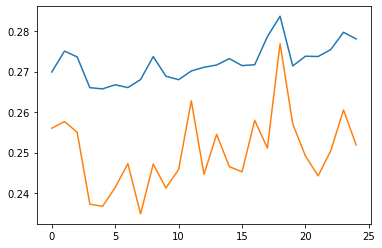

In [45]:
plt.figure()
plt.plot(loss_train)
plt.plot(loss_val)

In [36]:
 torch.cuda.empty_cache()

In [37]:
def validation():
    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    #track variables
    true_labels,pred_labels = [],[]

    # Predict
    for _, data in enumerate(testing_loader, 0):
        #print(_)
        
        #prepare data to feed into model
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
       
        with torch.no_grad():
            
            # Forward pass
            outputs = model(ids, mask, token_type_ids)
            b_logit_pred = outputs
            pred_label = b_logit_pred

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            targets = targets.to('cpu').numpy()

        #tokenized_texts.append(b_input_ids)
        #logit_preds.append(b_logit_pred)
        true_labels.append(targets)
        pred_labels.append(pred_label)

    # Flatten outputs
    #tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
    # print(true_labels)
    # print(pred_labels)
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]
    # Converting flattened binary values to boolean values
    true_bools = [tl==1 for tl in targets]
    
    return true_labels, true_bools, pred_labels

In [38]:
col =  ['Appeal to authority',
                                    'Appeal to fear/prejudice',
                                    'Black-and-white Fallacy/Dictatorship',
                                    'Causal Oversimplification',
                                    'Doubt',
                                    'Exaggeration/Minimisation',
                                    'Flag-waving',
                                    'Glittering generalities (Virtue)',
                                    'Loaded Language',
                                    'Misrepresentation of Someone\'s Position (Straw Man)',
                                    'Name calling/Labeling',
                                    'Obfuscation, Intentional vagueness, Confusion',
                                    'Presenting Irrelevant Data (Red Herring)',
                                    'Reductio ad hitlerum',
                                    'Repetition',
                                    'Slogans',
                                    'Smears',
                                    'Thought-terminating cliché',
                                    'Whataboutism',
                                    'Bandwagon',
                                    'Transfer',
                                    'Appeal to (Strong) Emotions']
col2 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,21]

In [46]:
#for epoch in range(EPOCHS):
targets, target_labels, outputs = validation()
#targets, outputs = validation()

outputs = [pl>0.50 for pl in outputs] #boolean output after thresholding

#print(outputs)
#print(target_labels)
#print(targets)

#outputs = np.array(outputs) >= 0.5
#targets = np.array(targets) >= 0.5
#outputs = np.argmax(outputs, axis=1)
#targets = np.argmax(targets, axis=1)

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro',zero_division=1)
f1_score_macro = metrics.f1_score(targets, outputs, average='macro', zero_division=1)
#print(f"epoch = {epoch}")
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
    
ml_cm = metrics.multilabel_confusion_matrix(targets,outputs, labels=col2)


Accuracy Score = 0.09285714285714286
F1 Score (Micro) = 0.43298969072164956
F1 Score (Macro) = 0.11665645279090658


In [47]:
print(metrics.classification_report(targets, outputs, target_names = col,
                                    digits=2, output_dict=False,zero_division=1))

                                                     precision    recall  f1-score   support

                                Appeal to authority       1.00      0.00      0.00         6
                           Appeal to fear/prejudice       1.00      0.00      0.00        17
               Black-and-white Fallacy/Dictatorship       1.00      0.00      0.00         2
                          Causal Oversimplification       1.00      0.00      0.00         7
                                              Doubt       1.00      0.00      0.00        17
                          Exaggeration/Minimisation       1.00      0.00      0.00        13
                                        Flag-waving       1.00      0.00      0.00        13
                   Glittering generalities (Virtue)       1.00      0.00      0.00        11
                                    Loaded Language       0.75      0.24      0.37        74
Misrepresentation of Someone's Position (Straw Man)       1.00      0

In [41]:
type(ml_cm)
print(ml_cm)

[[[134   0]
  [  6   0]]

 [[123   0]
  [ 17   0]]

 [[138   0]
  [  2   0]]

 [[133   0]
  [  7   0]]

 [[123   0]
  [ 17   0]]

 [[127   0]
  [ 13   0]]

 [[127   0]
  [ 13   0]]

 [[129   0]
  [ 11   0]]

 [[ 66   0]
  [ 74   0]]

 [[134   0]
  [  6   0]]

 [[ 81   0]
  [ 59   0]]

 [[138   0]
  [  2   0]]

 [[139   0]
  [  1   0]]

 [[135   0]
  [  5   0]]

 [[138   0]
  [  2   0]]

 [[129   0]
  [ 11   0]]

 [[  0  48]
  [  0  92]]

 [[137   0]
  [  3   0]]

 [[133   0]
  [  7   0]]

 [[140   0]
  [  0   0]]

 [[120   0]
  [ 20   0]]

 [[122   0]
  [ 18   0]]

 [[122   0]
  [ 18   0]]]


0


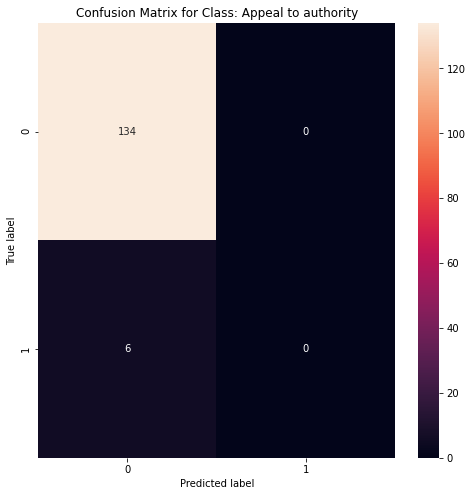

1


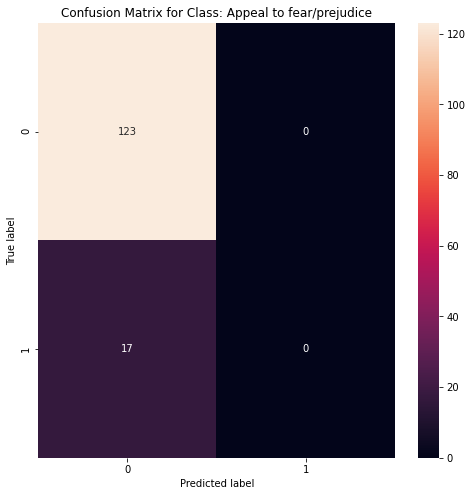

2


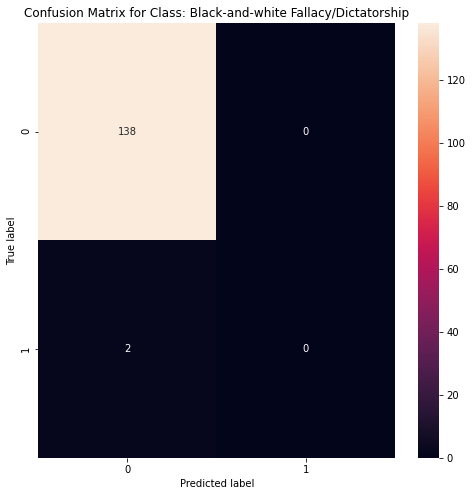

3


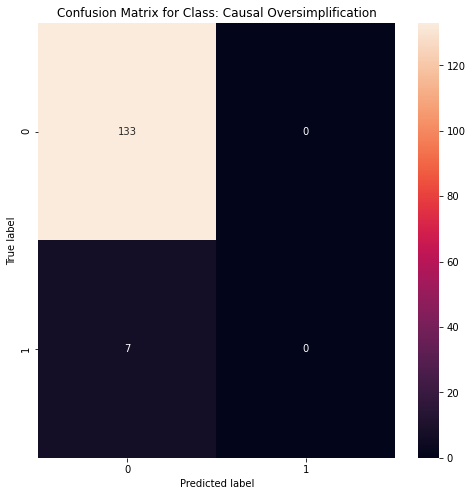

4


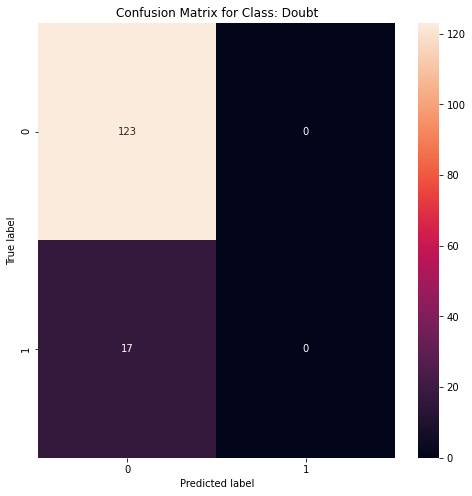

5


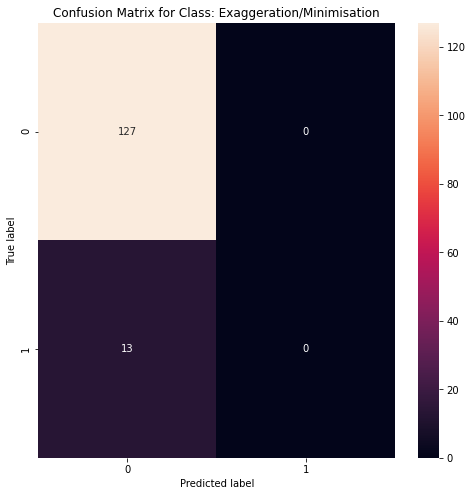

6


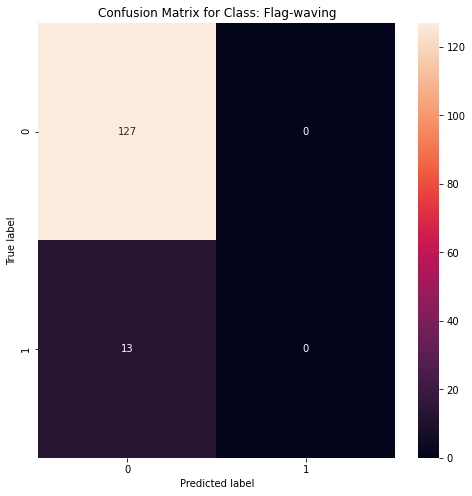

7


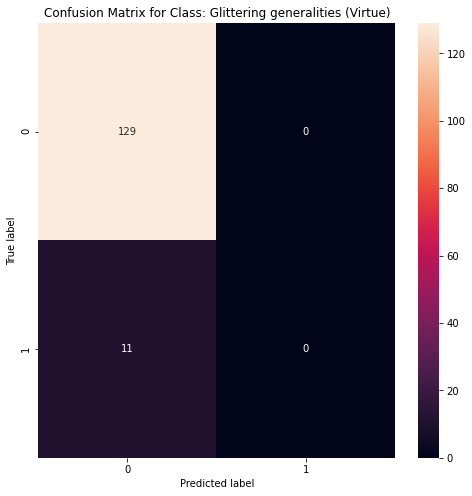

8


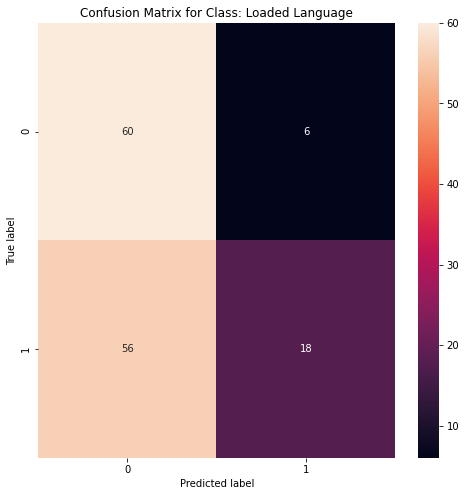

9


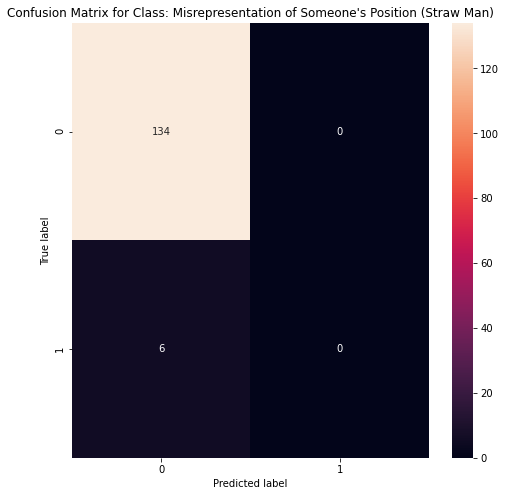

10


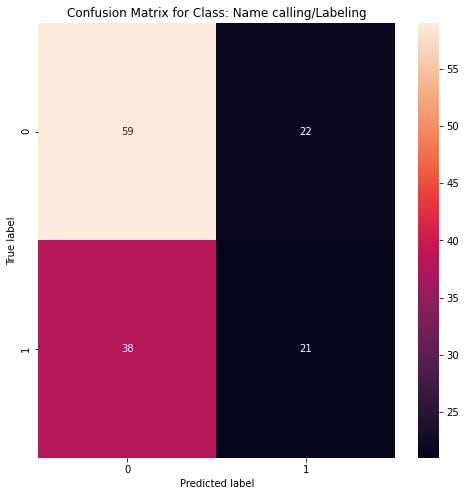

11


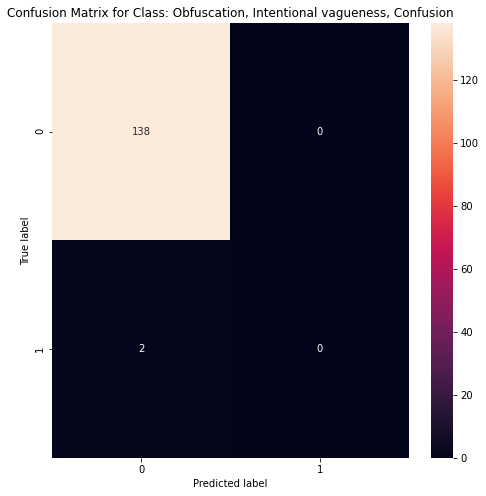

12


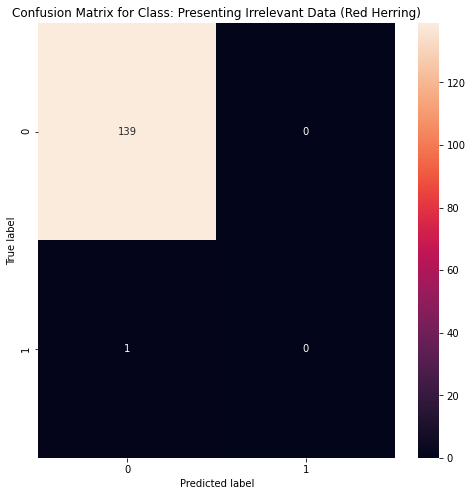

13


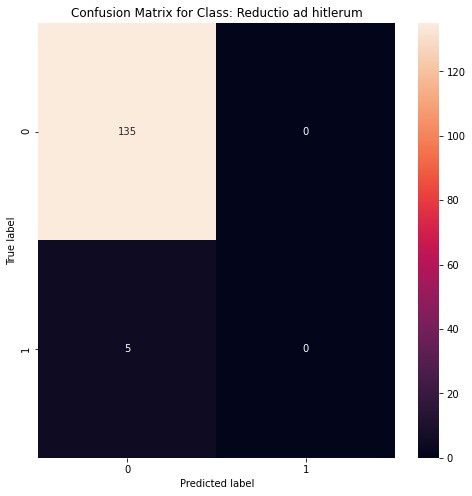

14


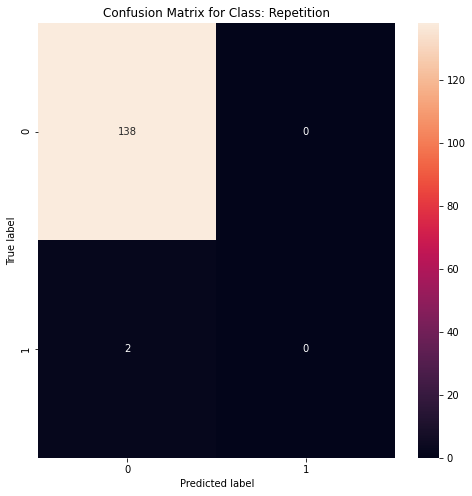

15


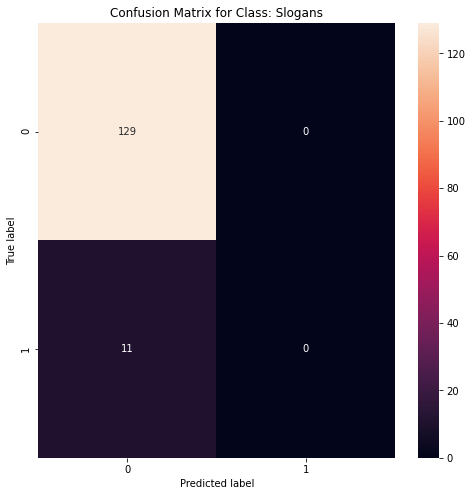

16


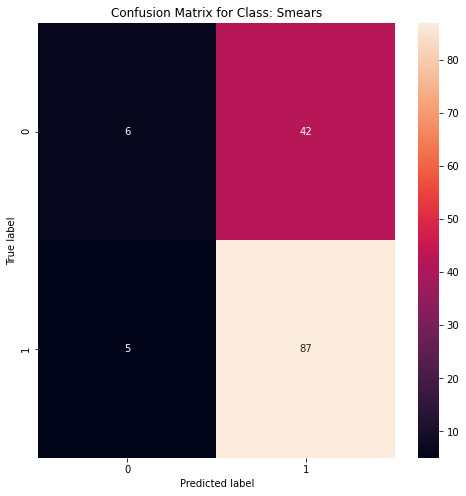

17


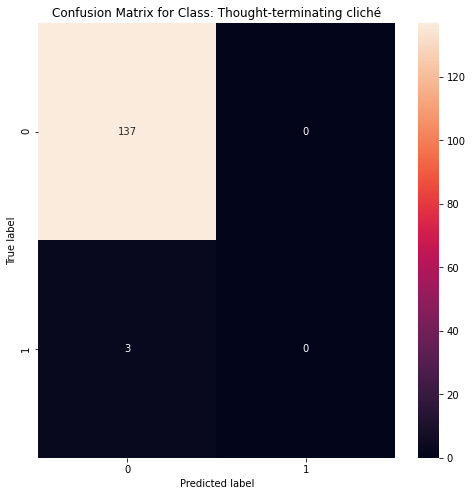

18


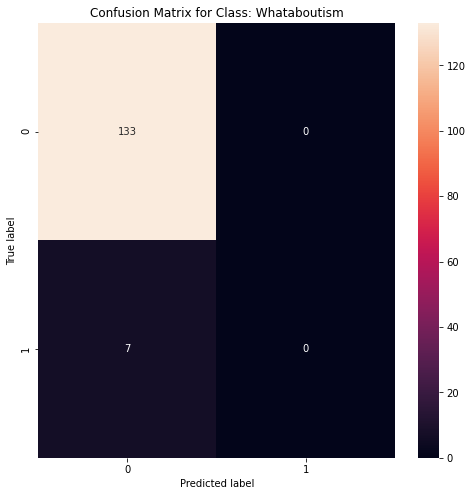

19


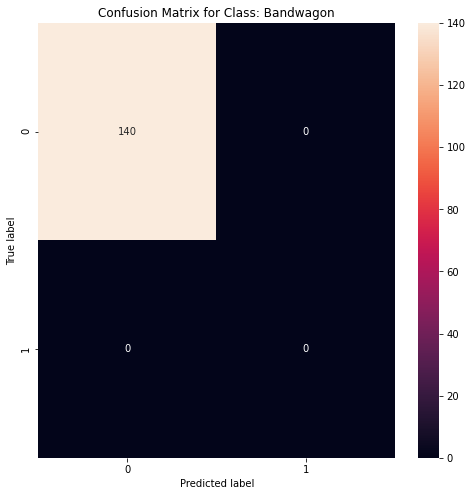

20


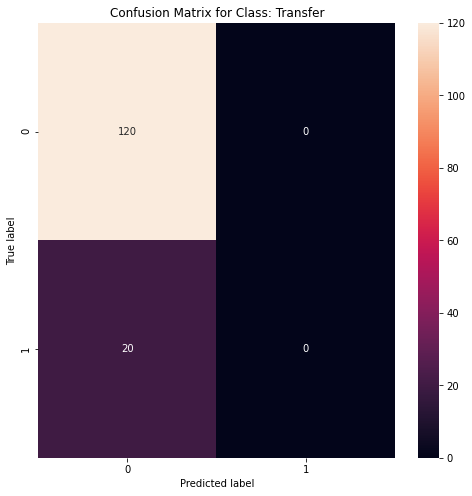

21


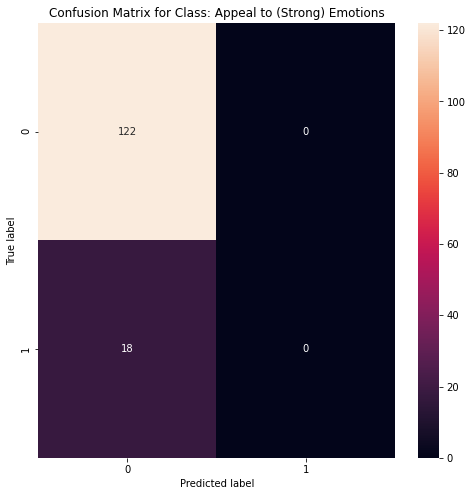

In [48]:
for i, class_cm in enumerate(ml_cm):
    if (i < 22):
        print(i)
        txt_title = "Confusion Matrix for Class: " + col[i] 
        # Transform to df for easier plotting
        plt.figure(figsize=(8,8))
        sns.heatmap(class_cm, annot=True, fmt='d')
        plt.title(txt_title)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
